#  Interactive segmentation

|   |   |
|---|---|
| Project  |    [Développez une preuve de concept](https://openclassrooms.com/fr/paths/148/projects/113/assignment)         |
| Date   |   April 2023   |
| Autor  | Ana Bernal                                                    |
| Data source | [A Large Scale Fish Dataset](https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset) |
| Mentor | Samir Tanfous | 
| Notebook number  | 1 of 1                                                    |

**Description:** In this notebook we compare the performances of two interactive segmentation models. For this we use the fish images dataset mentionned in the above table.

The two models are:

* [Segment Anything Model (SAM)](https://arxiv.org/abs/2304.02643), and
* [RITM](https://arxiv.org/pdf/2102.06583.pdf)

For generating masks we use the code from the examples in the notebooks provided by the authors of these articles. These notebooks can be found in the following links:

* [SAM example notebook](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb)
* [RITM example notebook](https://github.com/SamsungLabs/ritm_interactive_segmentation/blob/master/notebooks/test_any_model.ipynb)

## Some imports

In [23]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

Mounting drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# data_path = 'drive/MyDrive/data/fish_na/'
data_path = '../drive/MyDrive/data/fish_na/'
# fish_species = os.listdir(data_path)
# sample_path = data_path + fish_species[0] + '/' + fish_species[0] + '/' + '00181.png'
# sample_gt_path = data_path + fish_species[0] + '/' + fish_species[0] + '_GT/' + '00181.png'

In [4]:
ls

drive/  sample_data/


Importing fish images and ground truth

In [ ]:
# dataset = {}
# for species in fish_species:
#     species_name = '_'.join(species.split(' '))
#     dataset[species_name] = {}
#     dataset[species_name]['imgs'] = []
#     dataset[species_name]['gt'] = []

#     filenames = os.listdir(f'{data_path}/{species}/{species}')

#     for file in filenames:
#         img = cv2.imread(f'{data_path}/{species}/{species}/{file}')
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         gt = cv2.imread(f'{data_path}/{species}/{species}_GT/{file}',cv2.IMREAD_GRAYSCALE)
#         gt = gt > 0

#         dataset[species_name]['imgs'].append(img)
#         dataset[species_name]['gt'].append(gt)

In [44]:
import pickle

# with open('drive/MyDrive/data/images_dict.pickle', 'wb') as handle:
    # pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../drive/MyDrive/data/images_dict.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [43]:
ls

assets/     Dockerfile         LICENSE     README.md         train.py
config.yml  interactive_demo/  models/     requirements.txt
demo.py     isegm/             notebooks/  scripts/


In [45]:
dataset['Hourse_Mackerel'].keys()

dict_keys(['imgs', 'gt'])

In [12]:
dataset['Hourse_Mackerel']['gt'][0].shape

(445, 590)

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [14]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255/255, 0/255, 196/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


Taken from this gist: https://gist.github.com/JDWarner/6730886

In [74]:
def jaccard(im1, im2):
    """
    Computes the Jaccard metric, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    jaccard : float
        Jaccard metric returned is a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
    
    Notes
    -----
    The order of inputs for `jaccard` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    union = np.logical_or(im1, im2)

    return intersection.sum() / float(union.sum())



## Example image

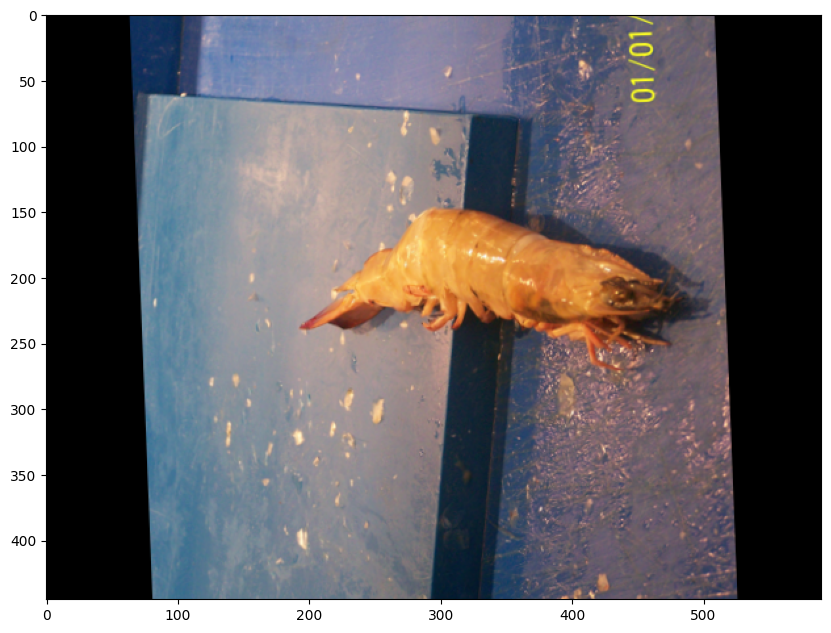

In [63]:
sample_img = dataset['Shrimp']['imgs'][5]
sample_gt = dataset['Shrimp']['gt'][5]

plt.figure(figsize=(10,10))
plt.imshow(sample_img)
plt.axis('on')
plt.show()

## Selecting objects with RITM

* Creer figure avec image, image+mask_gt, image+mask_sam image+mask_GT
* from ntoebook https://github.com/SamsungLabs/ritm_interactive_segmentation/blob/master/notebooks/test_any_model.ipynb

In [ ]:
!git clone https://github.com/SamsungLabs/ritm_interactive_segmentation.git

Cloning into 'ritm_interactive_segmentation'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 160 (delta 38), reused 33 (delta 32), pack-reused 70
Receiving objects: 100% (160/160), 5.81 MiB | 20.10 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [64]:
cd ritm_interactive_segmentation/

/content/ritm_interactive_segmentation


In [ ]:
import sys
import torch

sys.path.insert(0, '..')
from isegm.utils import vis, exp

from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample

device = torch.device('cuda:0')
# cfg = exp.load_config_file('../config.yml', return_edict=True)
cfg = exp.load_config_file('config.yml', return_edict=True)

init model

In [ ]:
weights_path = '../drive/MyDrive/weights/coco_lvis_h18s_itermask.pth'

In [ ]:
from isegm.inference.predictors import get_predictor

EVAL_MAX_CLICKS = 10
MODEL_THRESH = 0.49

checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, weights_path)
model = utils.load_is_model(checkpoint_path, device)

# Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
brs_mode = 'f-BRS-B'
predictor_RITM = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)

generate mask for one sample

[0.86607   0.9154517]


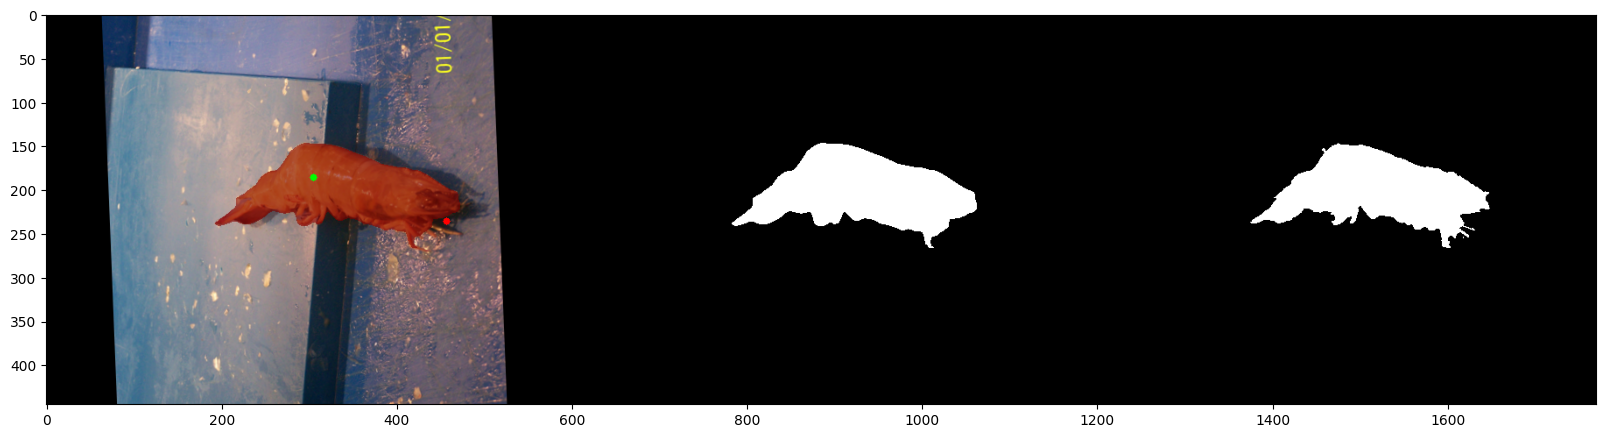

In [65]:
# sample_id = 12
TARGET_IOU = 0.9

sample = sample_img
gt_mask = sample_gt

clicks_list, ious_arr, pred = evaluate_sample(sample, gt_mask, predictor_RITM, 
                                              pred_thr=MODEL_THRESH, 
                                              max_iou_thr=TARGET_IOU, 
                                              max_clicks=EVAL_MAX_CLICKS
)

pred_mask = pred > MODEL_THRESH
draw = vis.draw_with_blend_and_clicks(sample, 
                                      mask=pred_mask, 
                                      clicks_list=clicks_list
)
draw = np.concatenate((draw,
    255 * pred_mask[:, :, np.newaxis].repeat(3, axis=2),
    255 * (gt_mask > 0)[:, :, np.newaxis].repeat(3, axis=2)
), axis=1)

print(ious_arr)

plt.figure(figsize=(20, 30))
plt.imshow(draw)
plt.show()

### Predict masks for all images

In [ ]:
TARGET_IOU = 0.9
# Names of the files in the format '00001.jpeg' to match original names
img_idx = [20*n + 1 for n in range(50)]
img_name = [str(idx).rjust(5,'0') + '.jpeg' for idx in img_idx]

for species in dataset.keys():

    dataset[species]['pred_RITM'] = []
    dataset[species]['iou_RITM'] = []
    dataset[species]['SAM_input'] = []

    for idx,img in enumerate(dataset[species]['imgs']):
        # Select image and ground truth mask
        sample = dataset[species]['imgs'][idx]
        gt_mask = dataset[species]['gt'][idx]

        # Predict with RITM
        clicks_list, ious_arr, pred = evaluate_sample(sample, gt_mask, predictor_RITM, 
                                                pred_thr=MODEL_THRESH, 
                                                max_iou_thr=TARGET_IOU, 
                                                max_clicks=EVAL_MAX_CLICKS
        )

        pred_mask_RITM = pred > MODEL_THRESH

        dataset[species]['pred_RITM'].append(pred_mask_RITM)

        # Save image from predicted mask
        im = Image.fromarray(pred_mask_RITM)
        name = ' '.join(species.split('_'))
        im.save(f'{data_path}{name}/RITM/{img_name[idx]}')

        # Record iou
        iou = jaccard(pred_mask_RITM,gt_mask)
        dataset[species]['iou_RITM'].append(iou)

        # Taking a (+) click from RITM model
        is_pos = False
        i = 0
        while is_pos == False:
            click_coord = clicks_list[i].coords
            is_pos = clicks_list[0].is_positive
        # SAM input point
        input_point = np.array([list(click_coord)[::-1]])
        dataset[species]['SAM_input'].append(input_point)


In [ ]:
# Verify that we generated the right # of images.
for file in os.listdir('../drive/MyDrive/data/fish_na'):
    print(len(os.listdir(f'../drive/MyDrive/data/fish_na/{file}/RITM')))

50
50
50
50
50
50
50
50
50


In [ ]:
# Saving updated dictionnary with data

with open('../drive/MyDrive/data/images_dict_RITM.pickle', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('../drive/MyDrive/data/images_dict_RITM.pickle', 'rb') as handle:
    # dataset = pickle.load(handle)

## Selecting objects with SAM

In [ ]:
cd ..

### Environment Set-up

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [58]:
using_colab = True

In [59]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pel4ydfq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pel4ydfq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=ca898f9f619a418b5aca4a1ab6008358b7d2689b92bb72551f3c6ea06b88633a
  Stored in directory: /tmp/pip-ephem-wheel-cache-sarzoin3/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segm

### Loading model and test

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [60]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor_SAM = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [62]:
predictor_SAM.set_image(sample_img)

To select the fish, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [67]:
# This input point was chosen with the help of RITM clicker
input_point = np.array([list(clicks_list[0].coords)[::-1]])
# input_point = clicks_list[0].coords
input_label = np.array([1])

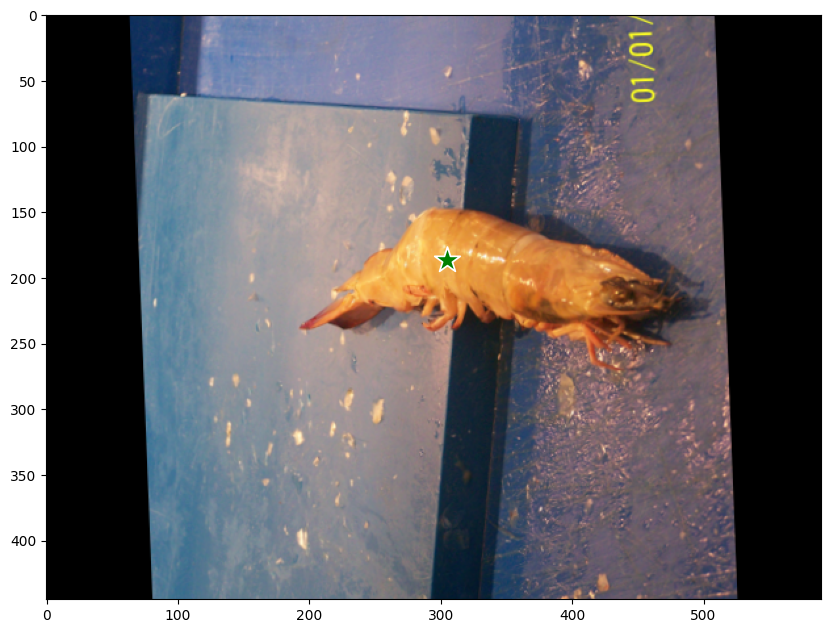

In [68]:
plt.figure(figsize=(10,10))
plt.imshow(sample_img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [70]:
masks, scores, logits = predictor_SAM.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [72]:
# select greatest model score
mask = masks[np.argmax(scores)]

In [ ]:
# Show ambiguous results
# for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
#     plt.imshow(sample_img)
    
#     show_mask(mask, plt.gca())
#     show_points(input_point, input_label, plt.gca())
#     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
#     plt.axis('off')
#     plt.show()  
  

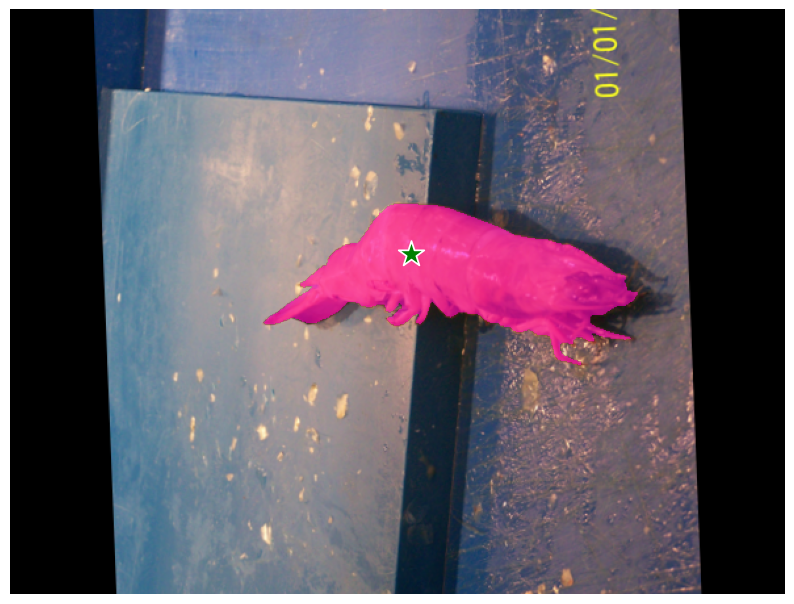

In [73]:
plt.figure(figsize=(10,10))
plt.imshow(sample_img)

show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()   

In [ ]:
# ground truth mask

jaccard(mask,sample_gt)


0.9771882046326393

### Predict masks for all images

In [75]:
# Names of the files in the format '00001.jpeg' to match original names
img_idx = [20*n + 1 for n in range(50)]
img_name = [str(idx).rjust(5,'0') + '.jpeg' for idx in img_idx]

for species in dataset.keys():

    dataset[species]['pred_SAM'] = []
    dataset[species]['iou_SAM'] = []
    # dataset[species]['SAM_input'] = []

    for idx,img in enumerate(dataset[species]['imgs']):
        # Select image and ground truth mask
        sample = dataset[species]['imgs'][idx]
        gt_mask = dataset[species]['gt'][idx]

        # Setting up image for sam predictor
        predictor_SAM.set_image(sample)
        # Choosing click point
        input_point = dataset[species]['SAM_input'][idx]
        input_label = np.array([1])

        # Predict with RITM
        masks, scores, logits = predictor_SAM.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )

        pred_mask_SAM = masks[np.argmax(scores)]

        dataset[species]['pred_SAM'].append(pred_mask_SAM)

        # Save image from predicted mask
        im = Image.fromarray(pred_mask_SAM)
        name = ' '.join(species.split('_'))
        im.save(f'{data_path}{name}/SAM/{img_name[idx]}')

        # Record iou
        iou = jaccard(pred_mask_SAM,gt_mask)
        dataset[species]['iou_SAM'].append(iou)

In [77]:
# Verify that we generated the right # of images.
for file in os.listdir('../drive/MyDrive/data/fish_na'):
    print(len(os.listdir(f'../drive/MyDrive/data/fish_na/{file}/SAM')))

50
50
50
50
50
50
50
50
50


## Comparison IoU SAM vs. RITM

We now explore the different scores obtained for the two segmentation models.

In [76]:
import pandas as pd